In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import numpy as np
import happybase
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

2023-07-20 16:18:11.403733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
import pandas_datareader
import datetime

In [5]:
pre_days = 2
mem_his_days = 17
epoch = 500
train_rate = 0.99
table_name = 'certificate'
column_family = 'feature'
stock_code = '002316'

In [19]:
connection = happybase.Connection('localhost', 9090, transport='framed', protocol='compact')
connection.open()
table = connection.table(table_name)
rows = table.scan(row_prefix=stock_code.encode('utf-8'))
df = pd.DataFrame()
idx = int(0)
for row in rows:
    date = row[0].decode('utf-8').split('_')[-1]
    cells = row[1]
    for column in cells:
        df.at[idx, column.decode('utf-8').split(':')[-1]] = np.float32(cells[column].decode('utf-8'))
    df.at[idx, 'date'] = date
    idx = idx + 1
connection.close()
df.dropna(inplace=True)
date = df['date']
df = df.drop(labels='date', axis=1)
print(df)

      macd_dea  macd_diff  macd_ema12  macd_ema26  macd_macd  trade_c  \
8       -0.130     -0.836   34.603001   35.439400     -1.412    31.18   
9       -0.352     -1.241   33.704102   34.944599     -1.776    28.76   
10      -0.561     -1.397   33.224998   34.622002     -1.672    30.59   
11      -0.737     -1.439   32.944199   34.383301     -1.405    31.40   
12      -0.891     -1.508   32.605099   34.113400     -1.234    30.74   
...        ...        ...         ...         ...        ...      ...   
2852     0.113      0.165    5.015800    4.851300      0.104     5.54   
2853     0.129      0.196    5.099500    4.903800      0.133     5.56   
2854     0.143      0.200    5.135000    4.935400      0.113     5.33   
2855     0.163      0.243    5.246500    5.003900      0.159     5.86   
2856     0.195      0.321    5.431700    5.111000      0.252     6.45   

          trade_e    trade_h   trade_hs    trade_l    trade_o    trade_v  \
8      90117944.0  31.690001  12.060000  30.400

In [20]:
# start = datetime.datetime(2000, 1, 1)
# end = datetime.datetime(2023, 7, 20)

# df = pandas_datareader.data.DataReader('NVDA', 'stooq', start, end)
# df.dropna(inplace=True)
# df.sort_index(inplace=True)

# normalize = lambda x: (x - x.min()) / (x.max() - x.min())

df['PreHigh'] = df['trade_h'].shift(1)
df["Change"] = df['trade_h'] / df['PreHigh']
print(df.head())

def change2label(x):
    if x < 0.91:
       return 0
    elif x < 0.92:
       return 1
    elif x < 0.93:
       return 2
    elif x < 0.94:
       return 3
    elif x < 0.95:
       return 4
    elif x < 0.96:
       return 5
    elif x < 0.97:
       return 6
    elif x < 0.98:
       return 7
    elif x < 0.99:
       return 8
    elif x < 1.:
       return 9
    elif x < 1.1:
       return 10
    elif x < 1.2:
       return 11
    elif x < 1.3:
       return 12
    elif x < 1.4:
       return 13
    elif x < 1.5:
       return 14
    elif x < 1.6:
       return 15
    elif x < 1.7:
       return 16
    elif x < 1.8:
       return 17
    elif x < 1.9:
       return 18
    return 19

df = df.dropna()
change = np.array(df['Change']).astype(np.float32)
df['Change'] = df['Change'].apply(change2label)
print(df.head())
df = df.drop('trade_h', axis=1)
df = df.drop('PreHigh', axis=1)
# df = df.drop('Low', axis=1)
# df = df.drop('Open', axis=1)
# df = df.drop('Close', axis=1)
print(df.head())


scaler = MinMaxScaler((0, 1))

sca = scaler.fit_transform(df.iloc[:, :-1])
label = np.array(df.iloc[:, -1])
print(sca)
print(label)

    macd_dea  macd_diff  macd_ema12  macd_ema26  macd_macd  trade_c  \
8     -0.130     -0.836   34.603001   35.439400     -1.412    31.18   
9     -0.352     -1.241   33.704102   34.944599     -1.776    28.76   
10    -0.561     -1.397   33.224998   34.622002     -1.672    30.59   
11    -0.737     -1.439   32.944199   34.383301     -1.405    31.40   
12    -0.891     -1.508   32.605099   34.113400     -1.234    30.74   

        trade_e    trade_h   trade_hs    trade_l    trade_o  trade_v  \
8    90117944.0  31.690001  12.060000  30.400000  30.469999  28941.0   
9   114190072.0  31.080000  16.139999  28.600000  30.889999  38735.0   
10  155427968.0  31.290001  21.440001  28.690001  28.690001  51455.0   
11  152094352.0  31.799999  20.629999  29.389999  30.170000  49503.0   
12   90032200.0  31.389999  12.130000  30.420000  30.500000  29106.0   

    trade_zd  trade_zde  trade_zf  kdj_d  kdj_j      kdj_k    PreHigh  \
8       1.53       0.47      4.20   8.50   8.50   8.500000        N

In [23]:
deq = collections.deque()

x = []
for row in sca:
    deq.append(list(row))
    if len(deq) > mem_his_days:
        deq.popleft()
    if len(deq) == mem_his_days:
        x.append(list(deq))
x = x[:-pre_days]
y = label[mem_his_days-1:-pre_days]
change = change[mem_his_days-1:-pre_days]

x, y = np.array(x).reshape(-1,mem_his_days,17,1), np.array(y)
print(x.shape)
print(y.shape)

(2842, 5, 17, 1)
(2842,)


In [24]:
total_num = len(x)
train_num = int(total_num * train_rate)
print(train_num)

2813


In [25]:
x_train, y_train, change_train = x[:train_num], y[:train_num], change[:train_num]
x_test, y_test, change_test = x[train_num:], y[train_num:], change[train_num:]

batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(train_num).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.shuffle(total_num - train_num).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)

sample = next(iter(train_ds))
print('x_train.shape:', sample[0].shape)
print('y_train.shape:', sample[1].shape)

x_train.shape: (128, 5, 17, 1)
y_train.shape: (128,)


In [26]:
input_shape = sample[0].shape[-3:]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,17,input_shape=input_shape,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64,17,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128,17,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dense(20,activation='softmax'))
model.build(input_shape=[None,mem_his_days,17])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 17, 32)         544       
                                                                 
 batch_normalization (Batch  (None, 5, 17, 32)         128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 5, 17, 32)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 8, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 8, 64)          32832     
                                                                 
 batch_normalization_1 (Bat  (None, 2, 8, 64)          2

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metrics])

# model.compile(optimizer=tf.keras.optimizers.RMSprop(),
#               loss=tf.keras.losses.MeanAbsoluteError(),
#               metrics=tf.keras.losses.MeanSquaredLogarithmicError())

def lr_schedule(epoch):
    if epoch > 350:
        return 0.00001
    if epoch > 200:
        return 0.00005
    if epoch > 150:
        return 0.0001
    if epoch > 100:
        return 0.0002
    if epoch > 50:
        return 0.0005
    return 0.001
        
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule,verbose=True)

history = model.fit(train_ds,
                    epochs=epoch,
                    validation_data=test_ds,
                    callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
22/22 [==============================] - 2s 26ms/step - loss: 2.6078 - sparse_categorical_accuracy: 0.3406 - val_loss: 2.9263 - val_sparse_categorical_accuracy: 0.1724 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/500
22/22 [==============================] - 0s 18ms/step - loss: 1.8185 - sparse_categorical_accuracy: 0.5020 - val_loss: 2.8546 - val_sparse_categorical_accuracy: 0.1724 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/500
22/22 [==============================] - 0s 21ms/step - loss: 1.4639 - sparse_categorical_accuracy: 0.5453 - val_loss: 2.7687 - val_sparse_categorical_accuracy: 0.1724 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/500
22/22 [==============================] - 0s 21ms/step - loss: 1.2744 - sparse_categorical_accuracy: 0.5588 - val_loss: 2.7197 - val_sparse_categorical_ac

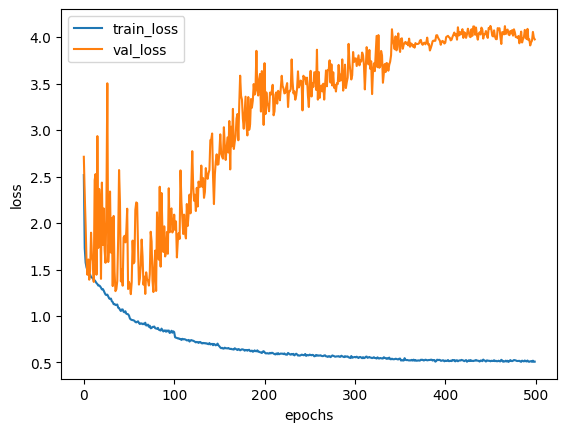

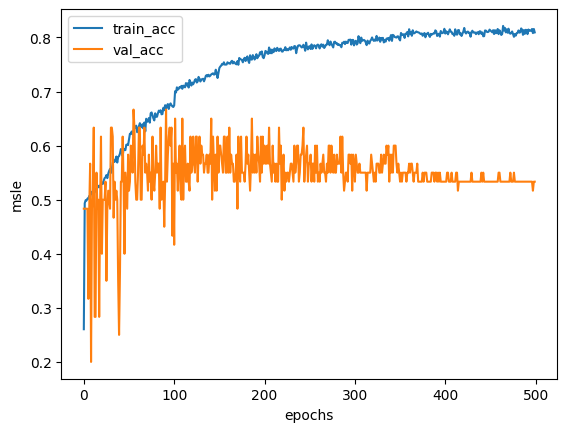

In [11]:
train_acc = history.history['sparse_categorical_accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_sparse_categorical_accuracy']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch), train_loss, label='train_loss')
plt.plot(range(epoch), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(range(epoch), train_acc, label='train_acc')
plt.plot(range(epoch), val_acc, label='val_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('msle')
plt.show()

1/1 [==============================] - 0s 14ms/step - loss: 3.9755 - sparse_categorical_accuracy: 0.5333


2/2 [==============================] - 0s 3ms/step
[ 9  8  9  9 10 10 10 10  9  7  9 10 10  9 10  9  8 10 10 10 10  9  8  9
 10 11 10  9 10  5  9  9  7  9  7 10 10 10 10 10 10  9  9  9  9  9  7 10
 10 10  9  9  9 10  9  9 10 10 10 10]


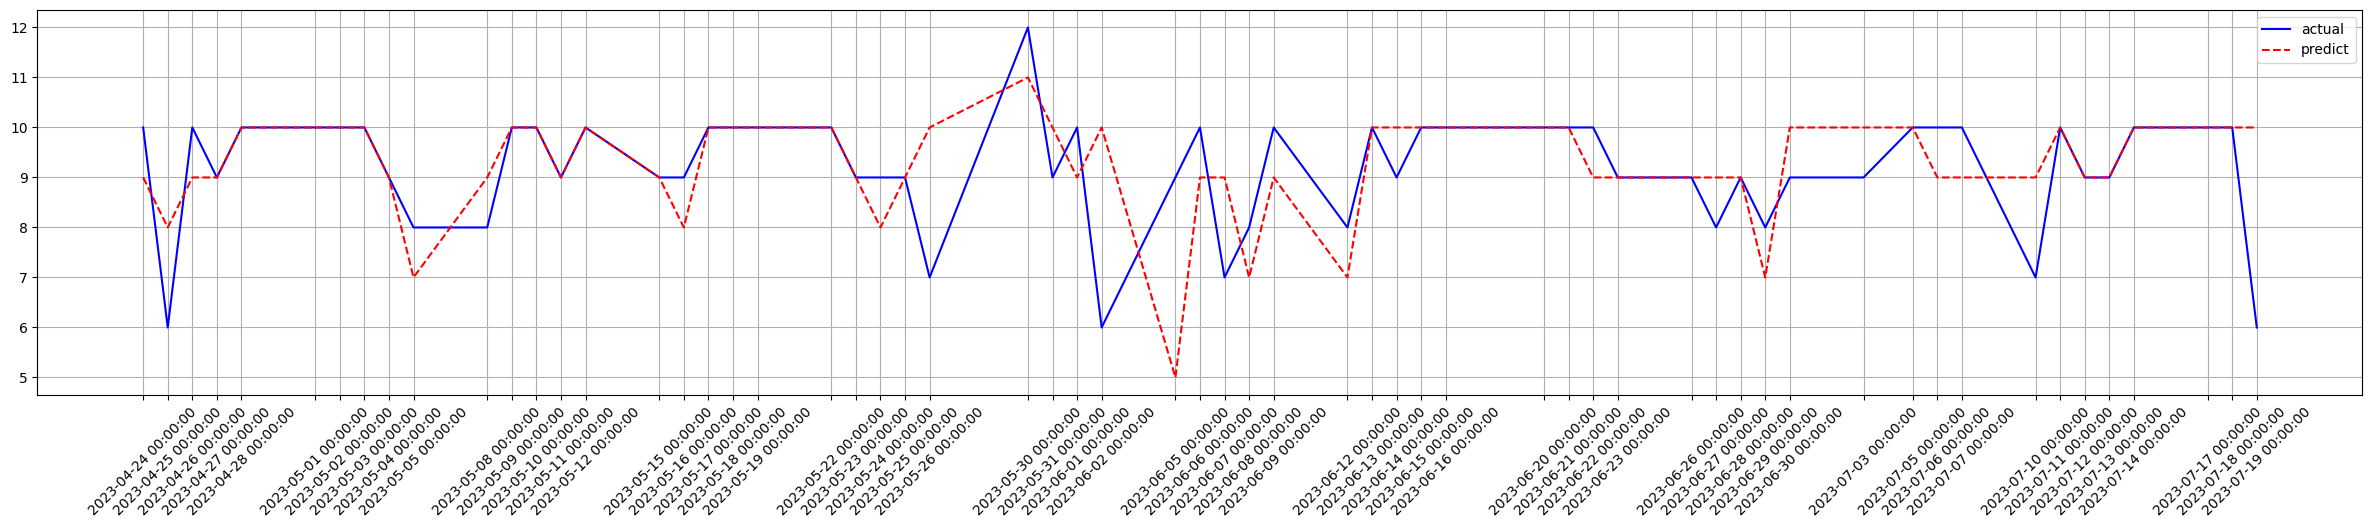

In [12]:
model.evaluate(test_ds)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

df_time = df.index[-len(y_test):]

fig = plt.figure(figsize=(30, 5))
axes = fig.add_subplot(111)
axes.plot(df_time, y_test, 'b-', label='actual')
axes.plot(df_time, y_pred, 'r--', label='predict')
print(y_pred)
axes.set_xticks(df_time[::1])
axes.set_xticklabels(df_time[::1],rotation=45)

plt.legend()
plt.grid()
plt.show()

In [13]:
price_actual = list()
price_pred = list()
price_actual.append(1.0)
price_pred.append(1.0)
def label2change(label):
    if label == 0:
        return 0.905
    elif label == 1:
        return 0.915
    elif label == 2:
        return 0.925
    elif label == 3:
        return 0.935
    elif label == 4:
        return 0.945
    elif label == 5:
        return 0.955
    elif label == 6:
        return 0.965
    elif label == 7:
        return 0.975
    elif label == 8:
        return 0.985
    elif label == 9:
        return 0.995
    elif label == 10:
        return 1.005
    elif label == 11:
        return 1.015
    elif label == 12:
        return 1.025
    elif label == 13:
        return 1.035
    elif label == 14:
        return 1.045
    elif label == 15:
        return 1.055
    elif label == 16:
        return 1.065
    elif label == 17:
        return 1.075
    elif label == 18:
        return 1.085
    elif label == 19:
        return 1.095
    return 0
    

for idx in range(1, len(y_test)):
    price_actual.append(price_actual[idx-1] * change_test[idx])
    price_pred.append(price_pred[idx-1] * label2change(y_pred[idx]))
print(price_actual)
print(price_pred)

[1.0, 0.9697823524475098, 0.9763106834224118, 0.9720655876899028, 0.975026650116737, 0.9809132316205051, 0.990296013329369, 1.0366906396175972, 1.0287545001765455, 1.0120228149737875, 0.9938993526105409, 1.0258650949527994, 1.0424544596871668, 1.0336424558676514, 1.038637046544214, 1.032821818777576, 1.0267568928229869, 1.0334996067168574, 1.0656436980119632, 1.0773810624802773, 1.1354973710230445, 1.1266497154093622, 1.1245091286559707, 1.1162322930492563, 1.091936905465802, 1.4084905261079272, 1.3974309493612636, 1.4961822424642148, 1.4375664883280914, 1.4288258675754366, 1.4448800869789962, 1.4115240855346507, 1.3970741755084237, 1.4091682836700008, 1.386513950438157, 1.4167315821278312, 1.4102738282900287, 1.4663212570676025, 1.5340700729778844, 1.5443804053529842, 1.5597925287057168, 1.569389354781218, 1.556010849937458, 1.5492502613573658, 1.5272559372841334, 1.5256505049102556, 1.496253397805367, 1.492864151468144, 1.4841234852218064, 1.5180157691017404, 1.530431000314209, 1.540

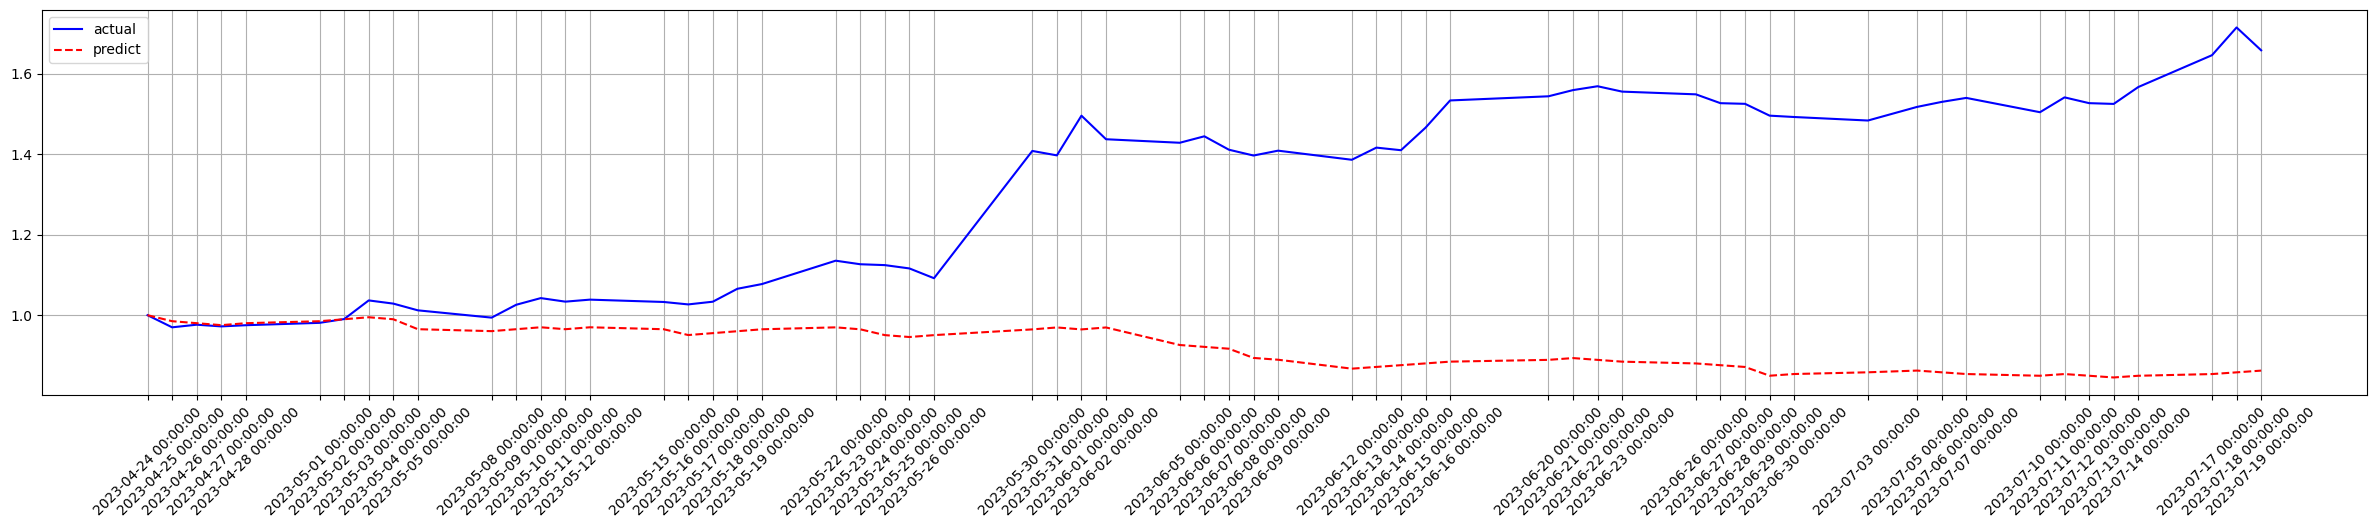

In [14]:
df_time = df.index[-len(y_test):]

fig = plt.figure(figsize=(30, 5))
axes = fig.add_subplot(111)
axes.plot(df_time, price_actual, 'b-', label='actual')
axes.plot(df_time, price_pred, 'r--', label='predict')

axes.set_xticks(df_time[::1])
axes.set_xticklabels(df_time[::1],rotation=45)

plt.legend()
plt.grid()
plt.show()

In [15]:
actual_profit_rate = 1
for idx in range(0, len(y_pred)):
    if y_pred[idx] >= 10:
        actual_profit_rate *= change_test[idx]
print(actual_profit_rate)

1.9012516887927133
